In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns 
import math
import statistics
import random

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [2]:
def var_threshold_selection(data, threshold=0.0):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# Create and re-normalize data set with cell counts

In [3]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

switch_isogenic_labels = True
human_only=True

norm_all_features = pd.read_csv(base_dir + '/feature_sets/Progenitors/0808_norm_data_all_features.csv', index_col=0)
norm_all_features = var_threshold_selection(norm_all_features)

df_data = pd.read_csv(base_dir + '/feature_sets/Progenitors/0714_stdev_corr_fs.csv', index_col=0)
data_cols = df_data.columns.tolist()

data = norm_all_features[data_cols]
cell_counts = norm_all_features['Cells_Number_Object_Number']

In [4]:
data_residuals = data.copy()
cell_count_corrs = pd.DataFrame()
features = data.columns.tolist()

# For every feature, get the linear regression and replace value with the residual
for feature in features:
    reg = LinearRegression().fit(data[feature].values.reshape(-1,1), cell_counts.values.reshape(-1,1))
    rscore = reg.score(data[feature].values.reshape(-1,1), cell_counts.values.reshape(-1,1))
    cell_count_corrs.loc[feature, 'r-squared'] = rscore
    cell_count_corrs.loc[feature, 'slope'] = reg.coef_
    cell_count_corrs.loc[feature, 'intercept'] = reg.intercept_
    
    # Find predicted feature value based on cell count
    predicted = reg.predict(data[feature].values.reshape(-1,1)).flatten()
    residuals = data[feature].values - predicted
    data_residuals[feature] = residuals

In [5]:
cell_count_corrs.sort_values(by='r-squared', ascending=False).head(10)

,r-squared,slope,intercept
Cytoplasm_Texture_Correlation_DNA_20_01,0.809411,-0.899673,-1.528556e-16
Nuclei_Neighbors_NumberOfNeighbors_2,0.785236,0.886135,1.083022e-16
Cells_Correlation_Correlation_DNA_Mito,0.782165,-0.884401,-2.043195e-16
Cells_Correlation_Overlap_ER_Brightfield,0.704664,0.839443,-1.896264e-15
Cytoplasm_Texture_InfoMeas1_RNA_10_00,0.690660,-0.831060,-2.645552e-16
Cells_RadialDistribution_RadialCV_ER_1of4,0.672240,-0.819903,-5.016942e-17
Cells_Intensity_LowerQuartileIntensity_DNA,0.669083,0.817975,1.271031e-17
Cells_Correlation_K_Brightfield_RNA,0.667023,0.816715,-2.051419e-16
Cells_RadialDistribution_RadialCV_DNA_1of4,0.644817,-0.803005,-4.536764e-16
Cytoplasm_RadialDistribution_MeanFrac_ER_4of4,0.633388,0.795857,8.493695e-16


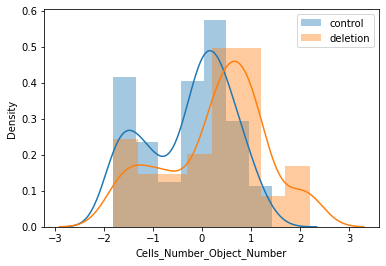

In [6]:
# Distribution of Cell counts vs control or deletion

temp = norm_all_features.copy()
temp['group'] = temp.index.str.split('_').map(lambda x: x[1])
temp = temp[['group', 'Cells_Number_Object_Number']]


sns.distplot(temp[temp['group']=='control']['Cells_Number_Object_Number'], label='control')
sns.distplot(temp[temp['group']=='deletion']['Cells_Number_Object_Number'], label='deletion')
plt.legend()
plt.show()

# Logistic Regression on residuals data

In [7]:
# residuals is the df of residualsalized features
residuals = data_residuals.copy()
residuals = residuals[data_cols]

human_only = True
if human_only:
    residuals = residuals[residuals.index.str.startswith('human')]


to_exclude = False
if to_exclude:
    residuals['cell_count'] = cell_counts
    residuals = residuals[residuals['cell_count'] > -1.39]
    residuals = residuals.drop(['cell_count'], axis=1)
    
swap_isogenic = True
labels = residuals.index.tolist()
if swap_isogenic:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
residuals.index = labels

residuals['label'] = residuals.index.str.split('_').map(lambda x: x[1])
residuals_xtrain, residuals_xtest, residuals_ytrain, residuals_ytest = train_test_split(residuals.drop(['label'], axis=1), residuals['label'], 
                                                                    test_size=0.3, random_state=4)
print(len(residuals_xtrain) + len(residuals_xtest))

logr = LogisticRegression(random_state=12, penalty='l2', C=1, max_iter=100).fit(residuals_xtrain, residuals_ytrain)
print(logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest))


348
0.9958847736625515 0.9142857142857143


In [8]:
# residuals is the df of residualsalized features
residuals = data_residuals.copy()
residuals = residuals[data_cols]

human_only = False
if human_only:
    residuals = residuals[residuals.index.str.startswith('human')]


to_exclude = False
if to_exclude:
    residuals['cell_count'] = cell_counts
    residuals = residuals[residuals['cell_count'] > -1.39]
    residuals = residuals.drop(['cell_count'], axis=1)
    
swap_isogenic = False
labels = residuals.index.tolist()
if swap_isogenic:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
residuals.index = labels

# random.seed(3)
residuals['label'] = residuals.index.str.split('_').map(lambda x: x[1])
residuals['patient_num'] = residuals.index.str.split('_').map(lambda x: x[2])

patients = list(set(residuals['patient_num']))
random.shuffle(patients)
train_nums = patients[0:36]
test_nums = patients[36:]

train_df = residuals[residuals['patient_num'].isin(train_nums)]
test_df = residuals[residuals['patient_num'].isin(test_nums)]

residuals_xtrain = train_df.drop(['label', 'patient_num'], axis=1)
residuals_ytrain = train_df['label']
residuals_xtest = test_df.drop(['label', 'patient_num'], axis=1)
residuals_ytest = test_df['label']
print(len(residuals_xtrain), len(residuals_ytrain), len(residuals_xtest), len(residuals_ytest))

logr = LogisticRegression(random_state=12, penalty='l2', C=1, max_iter=100).fit(residuals_xtrain, residuals_ytrain)
print(logr.score(residuals_xtrain, residuals_ytrain), logr.score(residuals_xtest, residuals_ytest))

284 284 96 96
0.9964788732394366 0.7291666666666666


# Logistic Regression on straight up data

In [9]:
# SPLIT WITH SKLEARN

# norm is the df of normalized features
norm = norm_all_features.copy()
norm = norm[data_cols]

human_only = False
if human_only:
    norm = norm[norm.index.str.startswith('human')]


to_exclude = False
if to_exclude:
    norm['cell_count'] = cell_counts
    norm = norm[norm['cell_count'] > -1.39]
    norm = norm.drop(['cell_count'], axis=1)
    
swap_isogenic = False
labels = norm.index.tolist()
if swap_isogenic:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
norm.index = labels
    
norm['label'] = norm.index.str.split('_').map(lambda x: x[1])
norm_xtrain, norm_xtest, norm_ytrain, norm_ytest = train_test_split(norm.drop(['label'], axis=1), norm['label'], 
                                                                    test_size=0.3, random_state=4)
print(len(norm_xtrain) + len(norm_xtest))

logr2 = LogisticRegression(random_state=2, penalty='l2', C=1, max_iter=130).fit(norm_xtrain, norm_ytrain)
print(logr2.score(norm_xtrain, norm_ytrain), logr2.score(norm_xtest, norm_ytest))

380
1.0 0.8859649122807017


In [10]:
# SPLIT BASED ON PATIENT NUMBER

#norm is the df of normalized features
norm = norm_all_features.copy()
norm = norm[data_cols]

human_only = True
if human_only:
    norm = norm[norm.index.str.startswith('human')]


to_exclude = False
if to_exclude:
    norm['cell_count'] = cell_counts
    norm = norm[norm['cell_count'] > -1.39]
    norm = norm.drop(['cell_count'], axis=1)
    
swap_isogenic = False
labels = norm.index.tolist()
if swap_isogenic:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
norm.index = labels
    
# random.seed(3)
norm['label'] = norm.index.str.split('_').map(lambda x: x[1])
norm['patient_num'] = norm.index.str.split('_').map(lambda x: x[2])

patients = list(set(norm['patient_num']))
random.shuffle(patients)
train_nums = patients[0:36]
test_nums = patients[36:]

train_df = norm[norm['patient_num'].isin(train_nums)]
test_df = norm[norm['patient_num'].isin(test_nums)]

norm_xtrain = train_df.drop(['label', 'patient_num'], axis=1)
norm_ytrain = train_df['label']
norm_xtest = test_df.drop(['label', 'patient_num'], axis=1)
norm_ytest = test_df['label']
print(len(norm_xtrain), len(norm_ytrain), len(norm_xtest), len(norm_ytest))

logr2 = LogisticRegression(random_state=2, penalty='l2', C=1, max_iter=130).fit(norm_xtrain, norm_ytrain)
print(logr2.score(norm_xtrain, norm_ytrain), logr2.score(norm_xtest, norm_ytest))

284 284 64 64
0.9964788732394366 0.921875
